In [1]:
%cd "F:\University\Master's Thesis\Datasets\rnd"

F:\University\Master's Thesis\Datasets\rnd


In [172]:
import torch
import numpy as np
import pandas as pd
import shutil

from darts import TimeSeries
from darts.models import NHiTSModel, TiDEModel, TFTModel, TCNModel
from darts.datasets import AusBeerDataset
from darts.dataprocessing.transformers.scaler import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.metrics import mae, mse, mape

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [191]:
import copy
from pathlib import Path

# List of columns you want to read
selected_columns = ["Timestamp [s]", "CPU usage [%]", "Memory usage [%]"]

file_path = 'VM001.csv'
df = pd.read_csv(file_path, usecols=selected_columns)

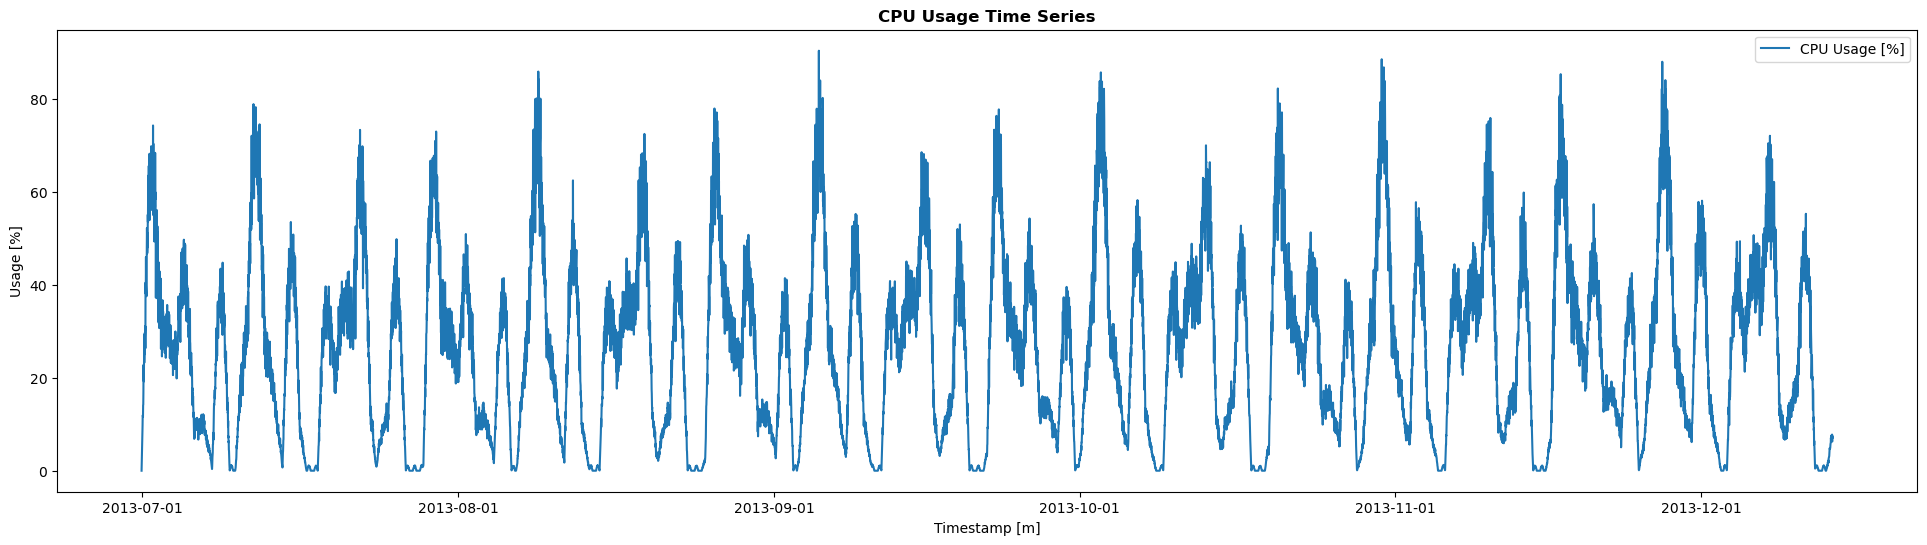

In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # Add this line

series = TimeSeries.from_dataframe(df, "Timestamp [s]", 'CPU usage [%]')
df = series.pd_dataframe()
df["Timestamp [s]"] = df.index

# Downsample data
downsampled_df = df[::20]

# Plotting using Matplotlib
plt.figure(figsize=(24, 6))
plt.plot(downsampled_df['Timestamp [s]'], downsampled_df['CPU usage [%]'], label='CPU Usage [%]')

# Bold the title
plt.title('CPU Usage Time Series', fontweight='bold')

# Adding labels and title
plt.xlabel('Timestamp [m]')
plt.ylabel('Usage [%]')
plt.legend()

# Turn off grid lines for the x-axis
plt.grid(False, axis='x')

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.savefig('cpu_trend.png')
# Show the plot
plt.show()


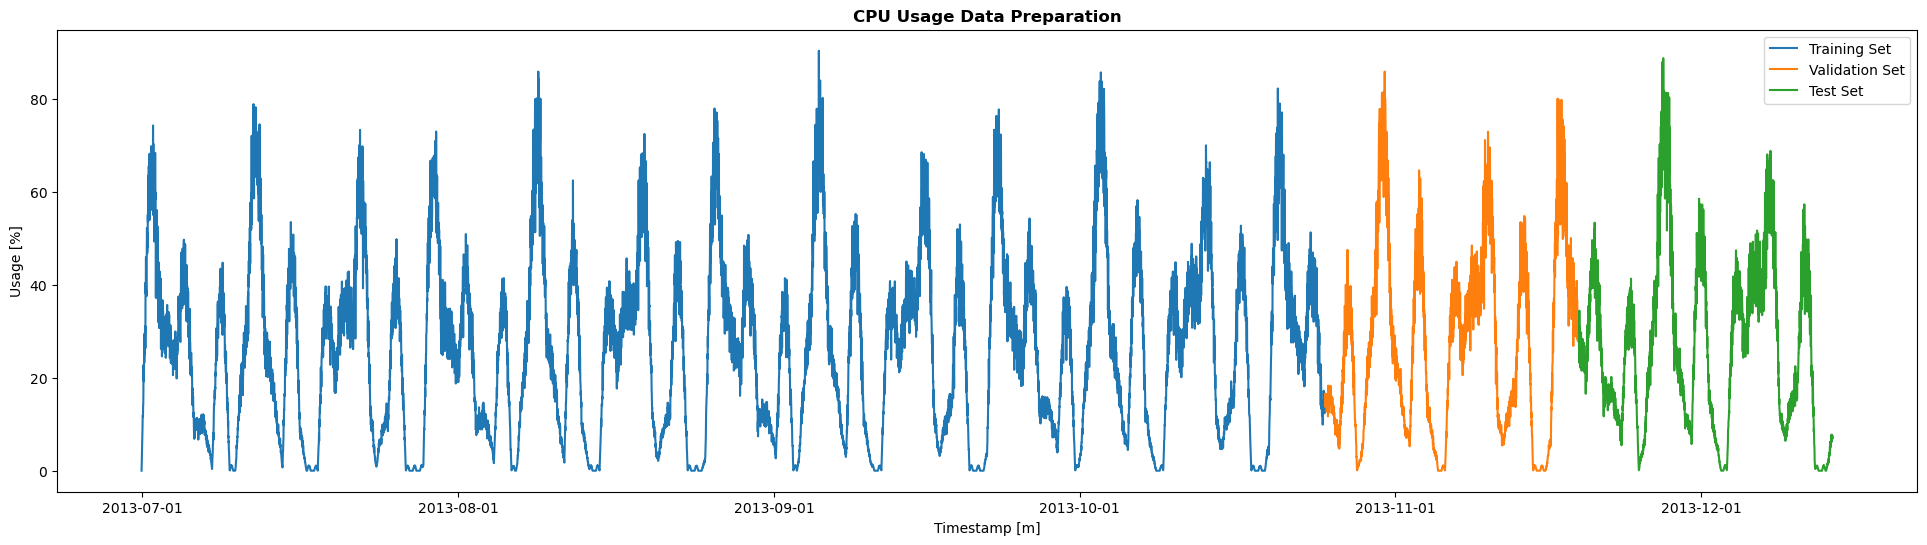

In [193]:
# Convert 'Timestamp [ms]' to datetime and set it as the index
df.set_index('Timestamp [s]', inplace=True)

# Preserve the 'Timestamp [ms]' column
df['Timestamp [s]'] = df.index

# Create a Darts TimeSeries object
series = TimeSeries.from_dataframe(df, "Timestamp [s]", 'CPU usage [%]')

train, temp = series.split_after(0.7)
val, test = temp.split_after(0.5)

# Converting to dataframe for plotting
train_df = train.pd_dataframe()
val_df = val.pd_dataframe()
test_df = test.pd_dataframe()


# Setting the timestamp column again
train_df["Timestamp [s]"] = train_df.index
val_df["Timestamp [s]"] = val_df.index
test_df["Timestamp [s]"] = test_df.index

# Downsizing the dataframe for better visualization
train_df = train_df[::20]
val_df = val_df[::20]
test_df = test_df[::20]

plt.figure(figsize=(24, 6))

# Plotting the timeseries
plt.plot(train_df['Timestamp [s]'], train_df['CPU usage [%]'], label='Training Set')
plt.plot(val_df['Timestamp [s]'], val_df['CPU usage [%]'], label='Validation Set')
plt.plot(test_df['Timestamp [s]'], test_df['CPU usage [%]'], label='Test Set')

# Bold the title
plt.title('CPU Usage Data Preparation', fontweight='bold')

# Adding labels and title
plt.xlabel('Timestamp [m]')
plt.ylabel('Usage [%]')
plt.legend()

# Turn off grid lines for the x-axis
plt.grid(False, axis='x')

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.savefig('cpu_trend_prepared.png')
# Show the plot
plt.show()

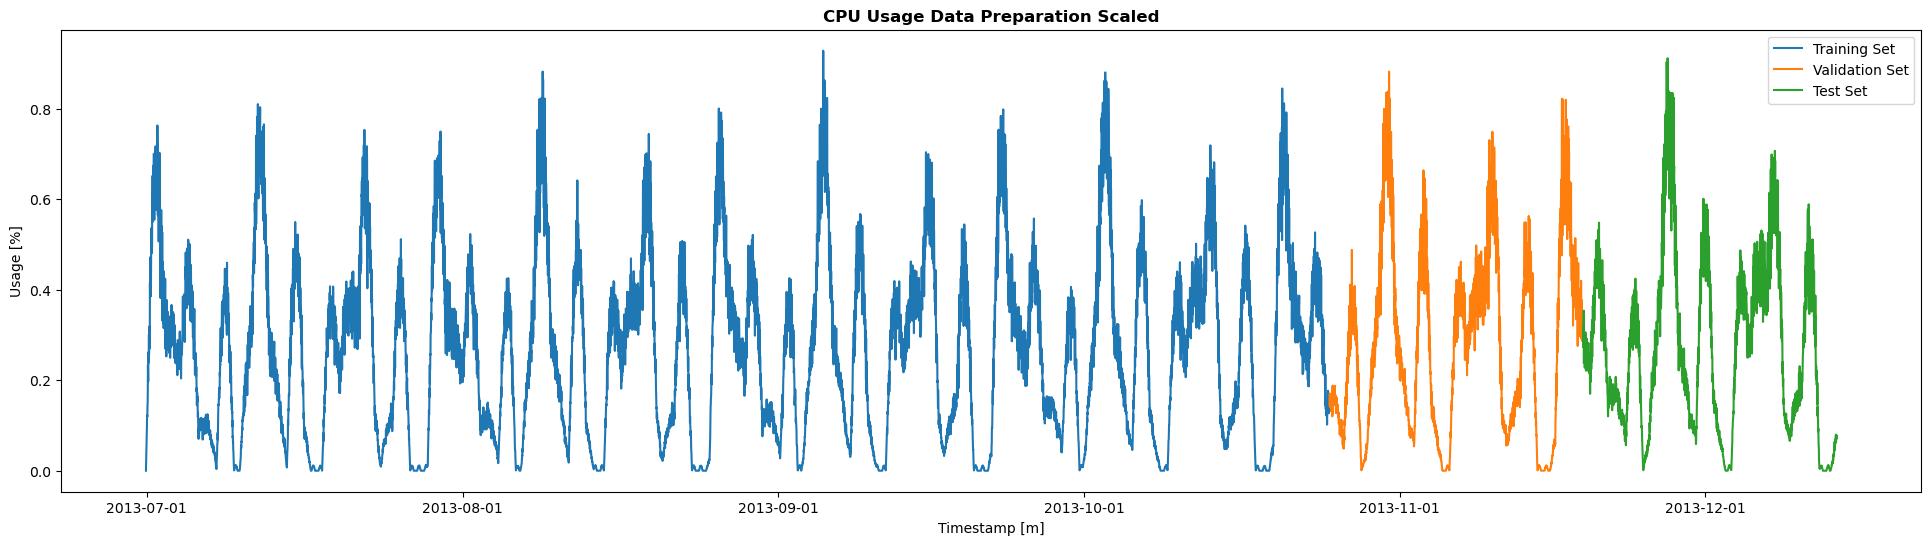

In [194]:
# Scaling the data
scaler = Scaler()  # default uses sklearn's MinMaxScaler
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)


# Converting to dataframe for plotting
train_df = train.pd_dataframe()
val_df = val.pd_dataframe()
test_df = test.pd_dataframe()


# Setting the timestamp column again
train_df["Timestamp [s]"] = train_df.index
val_df["Timestamp [s]"] = val_df.index
test_df["Timestamp [s]"] = test_df.index

# Downsizing the dataframe for better visualization
train_df = train_df[::20]
val_df = val_df[::20]
test_df = test_df[::20]

plt.figure(figsize=(24, 6))

# Plotting the timeseries
plt.plot(train_df['Timestamp [s]'], train_df['CPU usage [%]'], label='Training Set')
plt.plot(val_df['Timestamp [s]'], val_df['CPU usage [%]'], label='Validation Set')
plt.plot(test_df['Timestamp [s]'], test_df['CPU usage [%]'], label='Test Set')

# Bold the title
plt.title('CPU Usage Data Preparation Scaled', fontweight='bold')

# Adding labels and title
plt.xlabel('Timestamp [m]')
plt.ylabel('Usage [%]')
plt.legend()

# Turn off grid lines for the x-axis
plt.grid(False, axis='x')

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.savefig('cpu_trend_prepared_scaled.png')
# Show the plot
plt.show()

In [195]:
# Loading trained model
model_tide_cpu = TiDEModel.load('models/TiDE_bitbrains_cpu.pt')
model_nhits_cpu = NHiTSModel.load('models/NHiTS_bitbrains_cpu.pt')
model_tcn_cpu = TCNModel.load('models/TCN_bitbrains_cpu.pt')

models = {
    "NHiTS": model_nhits_cpu,
    "TiDE": model_tide_cpu,
    #"TFT": model_tft_cpu,
    "TCN": model_tcn_cpu
}

Predicting: |                                                    | 0/? [00:00<?, ?it/s]

Predicting: |                                                    | 0/? [00:00<?, ?it/s]

Predicting: |                                                    | 0/? [00:00<?, ?it/s]

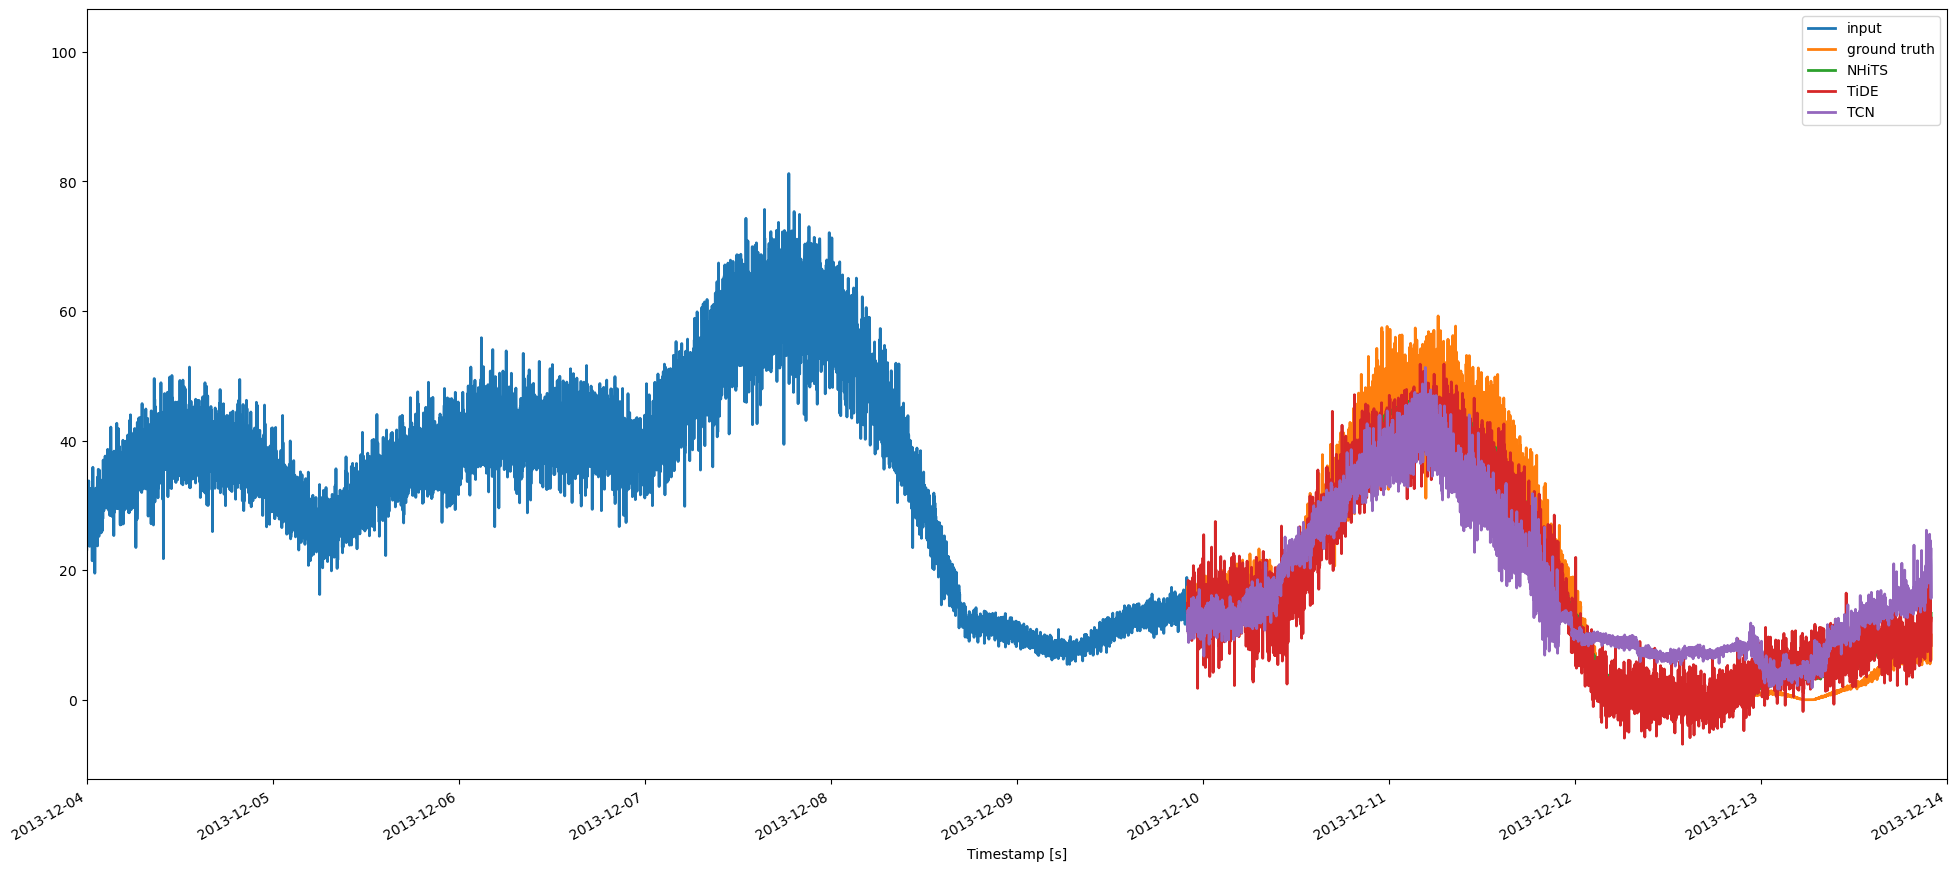

In [188]:
from darts.metrics import quantile_loss

# we will predict the next `pred_steps` points after the end of `pred_input`
pred_steps = 2880 * 2
pred_input = test[:-pred_steps]

# Set the specific start date
start_date = pd.Timestamp("2013-12-4")
end_date = pd.Timestamp("2013-12-14")

fig, ax = plt.subplots(figsize=(24, 10))
plt.xlim(start_date, end_date)

scaler.inverse_transform(pred_input).plot(label="input")
scaler.inverse_transform(test)[-pred_steps:].plot(label="ground truth", ax=ax)

result_accumulator = {}
# predict with each model and compute/store the metrics against the test sets
for model_name, model in models.items():
    pred_series = model.predict(n=pred_steps, series=pred_input)
    scaler.inverse_transform(pred_series).plot(label=model_name, ax=ax)

    test = test + 1e-5  # Add a small constant to avoid division by zero
    result_accumulator[model_name] = {
        "mae": mae(test, pred_series),
        "mse": mse(test, pred_series)
    }

Predicting: |                                                    | 0/? [00:00<?, ?it/s]

Predicting: |                                                    | 0/? [00:00<?, ?it/s]

Predicting: |                                                    | 0/? [00:00<?, ?it/s]

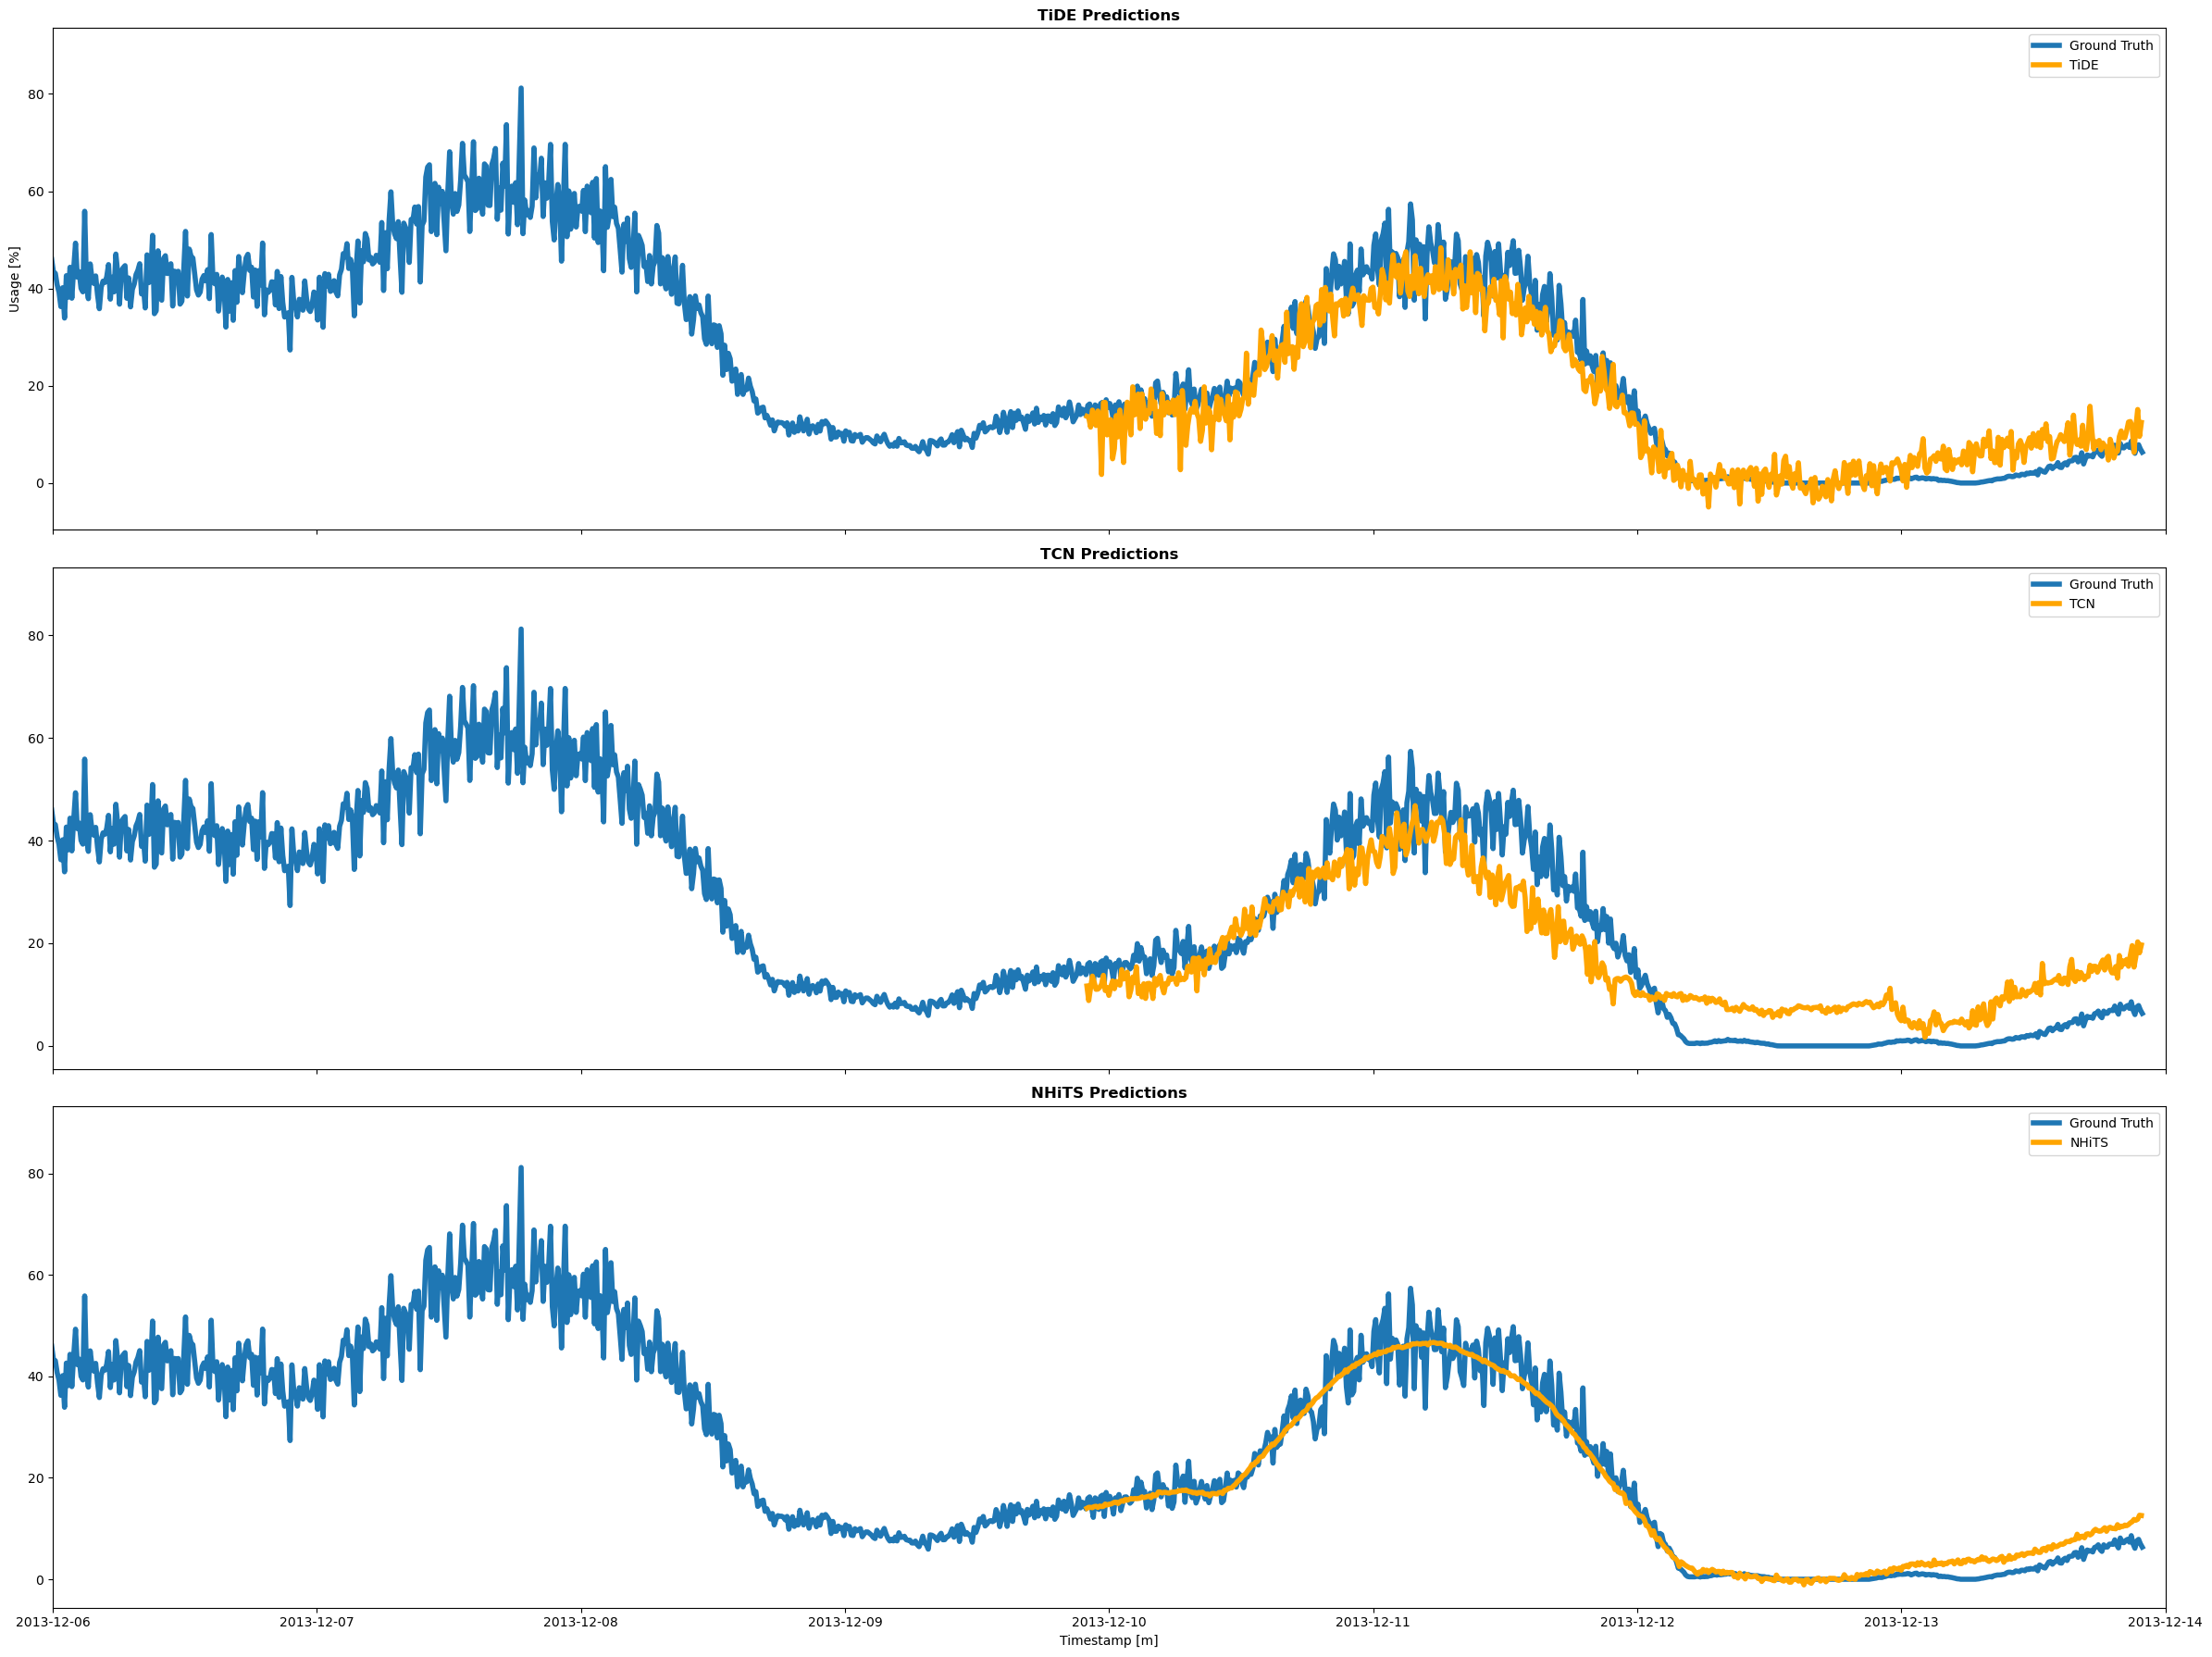

In [185]:
pred_series_tide = model_tide_cpu.predict(n=pred_steps, series=pred_input)
pred_series_tcn = model_tcn_cpu.predict(n=pred_steps, series=pred_input)
pred_series_nhits = model_nhits_cpu.predict(n=pred_steps, series=pred_input)


pred_series_tide = scaler.inverse_transform(pred_series_tide)
pred_series_tcn = scaler.inverse_transform(pred_series_tcn)
pred_series_nhits = scaler.inverse_transform(pred_series_nhits)
ground_truth = scaler.inverse_transform(test)

# Converting to dataframe for plotting
pred_input = pred_input.pd_dataframe()
pred_series_tide = pred_series_tide.pd_dataframe()
pred_series_tcn = pred_series_tcn.pd_dataframe()
pred_series_nhits = pred_series_nhits.pd_dataframe()
ground_truth = ground_truth.pd_dataframe()


# Setting the timestamp column again
pred_input["Timestamp [s]"] = pred_input.index
pred_series_tide["Timestamp [s]"] = pred_series_tide.index
pred_series_tcn["Timestamp [s]"] = pred_series_tcn.index
pred_series_nhits["Timestamp [s]"] = pred_series_nhits.index
ground_truth["Timestamp [s]"] = ground_truth.index

# Downsizing the dataframe for better visualization
pred_input = pred_input[::10]
pred_series_tide = pred_series_tide[::10]
pred_series_tcn = pred_series_tcn[::10]
pred_series_nhits = pred_series_nhits[::10]
ground_truth = ground_truth[::10]

start_date = pd.Timestamp("2013-12-6")
end_date = pd.Timestamp("2013-12-14")

# Set up the subplots
fig, axs = plt.subplots(3, 1, figsize=(24, 18), sharex=True)

# Iterate over each subplot and plot the corresponding data
for ax, model_output, model_name in zip(axs, [pred_series_tide, pred_series_tcn, pred_series_nhits],
                                               ['TiDE', 'TCN', 'NHiTS']):
    # Plot ground truth
    ax.plot(ground_truth['Timestamp [s]'][-pred_steps:], ground_truth['CPU usage [%]'][-pred_steps:], label='Ground Truth', linewidth=4)
    
    # Plot model output
    ax.plot(model_output['Timestamp [s]'], model_output['CPU usage [%]'], label=model_name, color="orange", linewidth=4)

    # Bold the title for each subplot
    ax.set_title(f'{model_name} Predictions', fontweight='bold')

    # Set y-axis label for the first subplot only
    if ax is axs[0]:
        ax.set_ylabel('Usage [%]')

    # Turn off grid lines for the x-axis
    ax.grid(False, axis='x')

    # Set x-axis locator and formatter
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.legend()

# Set common x-axis label
axs[-1].set_xlabel('Timestamp [m]')
plt.xlim(start_date, end_date)

# Adjust layout
plt.tight_layout()

# Save the plot to disk (change 'cpu_trend_predictions_subplots.png' to your desired filename and format)
plt.savefig('cpu_trend_predictions_subplots.png')

# Show the plot
plt.show()

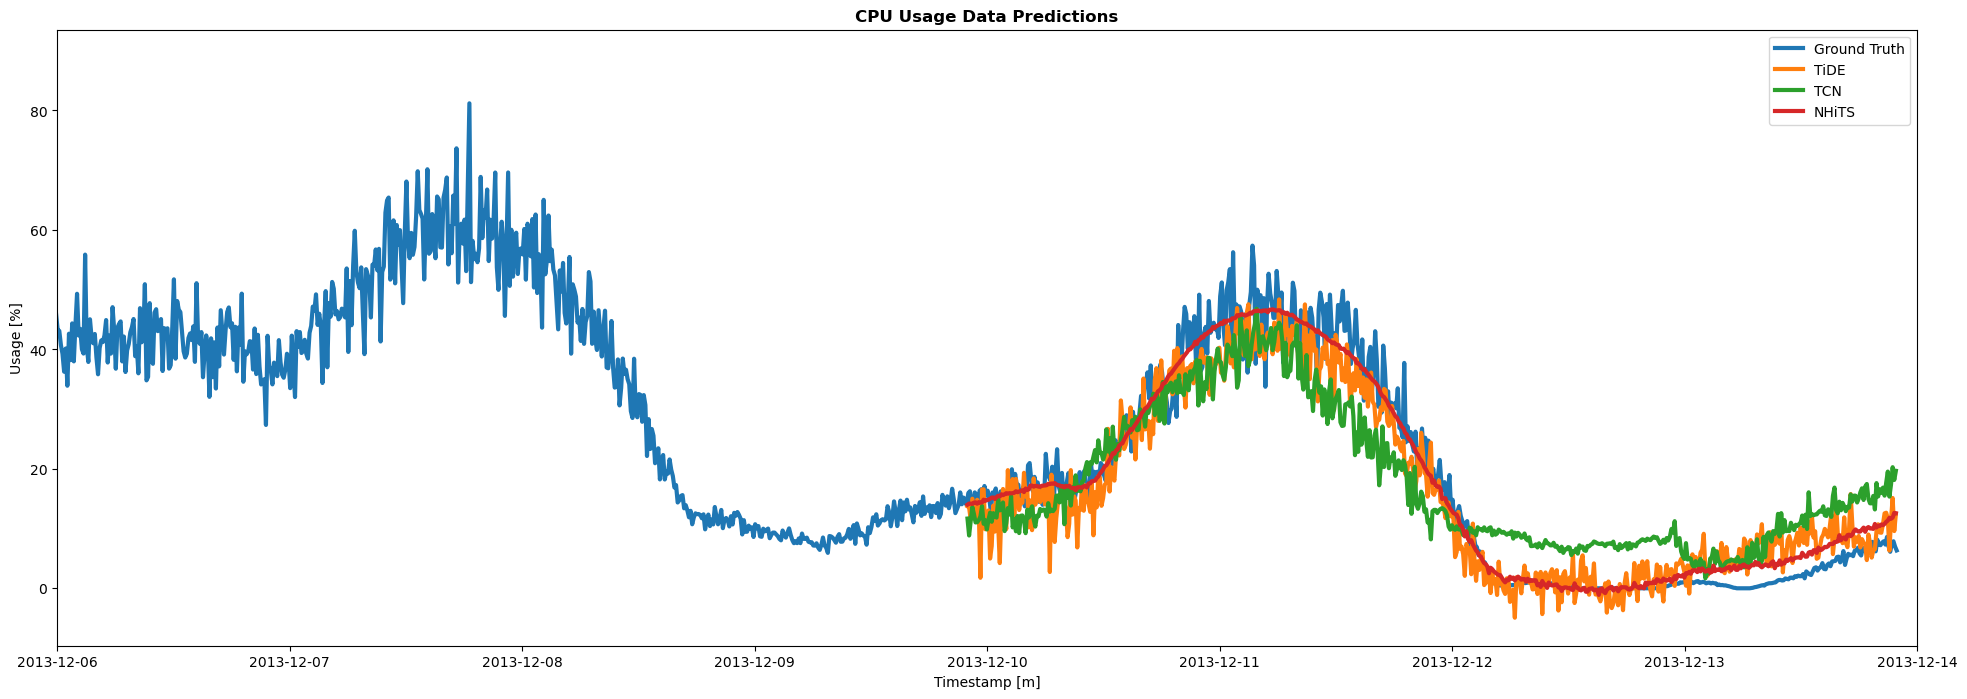

In [186]:
plt.figure(figsize=(24, 8))
start_date = pd.Timestamp("2013-12-6")
end_date = pd.Timestamp("2013-12-14")
plt.xlim(start_date, end_date)


# Plotting the timeseries with customizations
plt.plot(ground_truth['Timestamp [s]'][-pred_steps:], ground_truth['CPU usage [%]'][-pred_steps:], label='Ground Truth', linewidth=3)
plt.plot(pred_series_tide['Timestamp [s]'], pred_series_tide['CPU usage [%]'], label='TiDE', linewidth=3)
plt.plot(pred_series_tcn['Timestamp [s]'], pred_series_tcn['CPU usage [%]'], label='TCN',  linewidth=3)
plt.plot(pred_series_nhits['Timestamp [s]'], pred_series_nhits['CPU usage [%]'], label='NHiTS', linewidth=3)

# Bold the title
plt.title('CPU Usage Data Predictions', fontweight='bold')
plt.xlabel('Timestamp [m]')
plt.ylabel('Usage [%]')
plt.legend()

# Turn off grid lines for the x-axis
plt.grid(False, axis='x')

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Save the plot to disk (change 'cpu_trend_predictions.png' to your desired filename and format)
plt.savefig('cpu_trend_predictions.png')

# Show the plot
plt.show()



In [187]:
results_df = pd.DataFrame.from_dict(result_accumulator, orient="index")
results_df.head()

,mae,mse
NHiTS,0.023685,0.000994
TiDE,0.042419,0.002916
TCN,0.069942,0.006595


In [197]:
pred_series_nhits = model_nhits_cpu.predict(n=pred_steps, series=pred_input)
pred_series_nhits = scaler.inverse_transform(pred_series_nhits)
sample = pred_series_nhits.pd_dataframe()
sample.head(15)

Predicting: |                                                    | 0/? [00:00<?, ?it/s]

component,CPU usage [%]
Timestamp [s],
2013-12-09 21:59:00,14.007266
2013-12-09 22:00:00,14.053700
2013-12-09 22:01:00,14.058797
2013-12-09 22:02:00,14.361495
2013-12-09 22:03:00,13.926062
2013-12-09 22:04:00,14.143917
2013-12-09 22:05:00,14.077610
2013-12-09 22:06:00,14.304139
2013-12-09 22:07:00,14.215333
